### COMSM0140: Internet Economics and Financial Technology 2023. Main coursework. 

### Imran Zamin Ali

### Initial Setup

In [1]:
# Initial Setup:
# Import all the libraries we need

from tqdm import tqdm

# Copied from the solutions from the Week 8 lab (https://www.ole.bris.ac.uk/bbcswebdav/pid-8039179-dt-content-rid-47461249_2/xid-47461249_2)
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

from BSE import market_session

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.xlabel('Time')
    plt.ylabel('Trade Price')
    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')  

### Part A

In [2]:
# given a tuple of the algos, a tuple of the percentages for that trader and the number of traders return the specs
def get_traders_specs(algos, percentages, num_traders):
    if sum(percentages) != 100:
        raise Exception('The percentages should add to 100')
    if len(algos) != len(percentages):
        raise Exception(f'algos len: {len(algos)} %s len: {len(percentages)} are not equal')
    
    num_traders_each = tuple(round(percent * num_traders / 100) for percent in percentages)
    if sum(num_traders_each) != num_traders:
        raise Exception('num traders each != num traders')
    return list(zip(algos, num_traders_each))

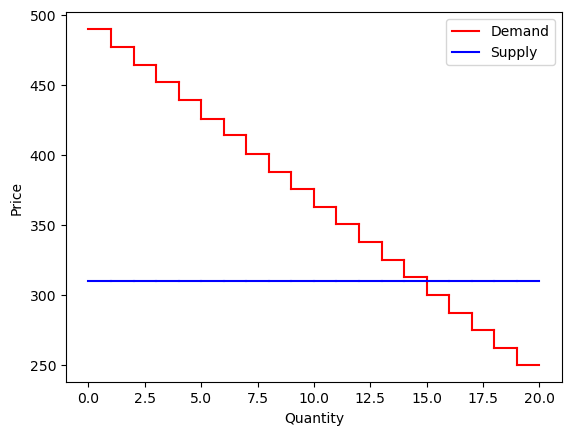

In [3]:
sup_range = (310, 310)
dem_range = (250, 490)
num_buyers = 20
num_sellers = 20
r = 50
r_vals = (r, 100 - r)
algos = ('SHVR', 'ZIC')
seller_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_sellers)
buyer_specs = get_traders_specs(algos=algos, percentages=r_vals, num_traders=num_buyers)
traders_specs = {'sellers': seller_specs, 'buyers': buyer_specs}

plot_sup_dem(num_buyers, [sup_range], num_sellers, [dem_range], 'fixed')



In [9]:
start_time = 0
end_time = 15 * 60
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': 'fixed'}]
order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
              'interval': order_interval, 'timemode': 'periodic'}
verbose = False
trial_id = 'smith_chart_2'
dump_flags = {'dump_blotters': True, 'dump_lobs': True, 'dump_strats': True,
              'dump_avgbals': True, 'dump_tape': True}

In [10]:
random.seed(100) # changing the seed value will give us different seqences of random numbers

market_session(trial_id, start_time, end_time, traders_specs, order_sched, dump_flags, verbose)

# TODO create a for loop that runs to n. Changes the seed each time as well as the trial id. Dumps the avgbals. Take the total profits for each trader type from the last line of the csv file and puts it into a dataframe

# 

Some text...

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT. 

In [2]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

C:\Users\izami\AppData\Local\Temp\ipykernel_11952\1902107979.py:3: DeprecationWarning: nbformat.current is deprecated since before nbformat 3.0

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  from nbformat import current


In [3]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "cw.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 12. Limit is 2000 words.
